In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import backend as K # สำหรับ Dice Loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import cv2
from glob import glob
import seaborn as sns

In [ ]:
import zipfile

zip_path = "pipe_staple.zip"
extract_path = "pipe_staple"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("แตกไฟล์เรียบร้อยแล้ว")

แตกไฟล์เรียบร้อยแล้ว


In [9]:

# 1. การกำหนดค่าและเตรียม PATH
DATA_DIR = 'pipe_staple'

IMG_SIZE = (128, 128) # ลองเปลี่ยนเป็นค่านี้
BATCH_SIZE = 16 # หรือ 32
EPOCHS = 15 # เพิ่ม Epochs เพื่อการเรียนรู้ที่ดีขึ้น
SEED = 42

# เงื่อนไขการ Classification ที่ปรับให้ Sensitive ขึ้น
SEGMENTATION_THRESHOLD = 0.35  # ลดลงจาก 0.5 เพื่อจับพิกเซล Defect ที่โมเดลมั่นใจน้อยลง
PIXEL_COUNT_THRESHOLD = 15     # ลดลงจาก 50 เพื่อจับ Defect ขนาดเล็ก

In [10]:
import os
print(f"Current Working Directory: {os.getcwd()}")
print(f"Looking for data at: {os.path.abspath(DATA_DIR)}")
if os.path.exists(DATA_DIR):
    print("Folder exists!")
    print("Contents:", os.listdir(DATA_DIR))
else:
    print("Folder NOT found!")

Current Working Directory: d:\Data AutoVI\Data
Looking for data at: d:\Data AutoVI\Data\pipe_staple
Folder exists!
Contents: ['defects_config.json', 'defect_example.png', 'ground_truth', 'license.txt', 'readme.md', 'test', 'train']


In [4]:
DATA_DIR = 'pipe_staple/pipe_staple'

In [11]:

# 2. Loss Function และ Metric สำหรับ Segmentation ที่จัดการ Imbalance ได้ดี


# Dice Coefficient (Metric)
def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (Loss Function)
def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

# Combined Loss: Dice Loss + Binary Crossentropy (มักจะเสถียรและแม่นยำกว่า)
def combined_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)



In [13]:

# 3. ฟังก์ชันช่วยโหลดและประมวลผลภาพ

def load_all_data_and_masks(base_dir, img_size):
    """
    โหลดภาพ Input และ Segmentation Mask สำหรับการเทรน
    ใช้โครงสร้าง GT: ground_truth/missing/XXXX/0000.png
    """
    X = []
    Y = []

    # 3.1. ดึง Path ของภาพ 'good' สำหรับ Training
    good_files = glob(os.path.join(base_dir, 'train', 'good', '*.png'))
    print(f"Found {len(good_files)} good images for training.")

    # 3.2. ดึง Path ของภาพ 'missing' สำหรับการเรียนรู้ Defect
    missing_dir = os.path.join(base_dir, 'test', 'missing')
    missing_files = glob(os.path.join(missing_dir, '*.png'))
    print(f"Found {len(missing_files)} missing images for defect learning.")

    # โหลดและเตรียมข้อมูล Good
    for img_path in good_files:
        img = img_to_array(load_img(img_path, target_size=img_size)) / 255.0
        mask = np.zeros(img_size + (1,), dtype=np.float32) # Mask สีดำสนิท
        X.append(img)
        Y.append(mask)

    # โหลดและเตรียมข้อมูล Missing พร้อม Ground Truth
    gt_base_dir = os.path.join(base_dir, 'ground_truth', 'missing')
    for img_path in missing_files:
        img = img_to_array(load_img(img_path, target_size=img_size)) / 255.0

        file_name = os.path.basename(img_path)

        # ดึงชื่อโฟลเดอร์ 4 หลักจากชื่อไฟล์ Missing (เช่น '0000' จาก '0000_missing.png')
        folder_name = file_name[:4]

        # Path ของ Ground Truth: ground_truth/missing/XXXX/0000.png
        gt_path = os.path.join(gt_base_dir, folder_name, '0000.png')

        if os.path.exists(gt_path):
            mask = img_to_array(load_img(gt_path, target_size=img_size, color_mode='grayscale')) / 255.0
            mask = (mask > 0.0).astype(np.float32)
        else:
            print(f"Warning: Ground truth not found at expected path: {gt_path}. Using black mask.")
            mask = np.zeros(img_size + (1,), dtype=np.float32)

        X.append(img)
        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)

    # แบ่งเป็น Train และ Validation
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=SEED)

    return X_train, Y_train, X_val, Y_val

In [14]:

# 4. การสร้างโมเดล U-Net

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Add, Activation
from tensorflow.keras.models import Model
import tensorflow as tf

# 1. สร้าง Recurrent Residual Convolutional Unit (RRCU)
def rr_block(x, filters, t=2):
    """
    Recurrent Residual Block:
    - x: Input tensor
    - filters: จำนวน Filters
    - t: จำนวน time steps ของการวนซ้ำ (Recurrent) (ค่าปกติคือ 2)
    """
    # 1x1 Conv เพื่อปรับจำนวน Channel ของ Input ให้ตรงกับ Filters (สำหรับ Shortcut)
    x_skip = Conv2D(filters, 1, padding='same')(x)

    # สร้าง Layer Convolution ที่จะใช้แชร์น้ำหนัก (Shared Weights)
    conv_shared = Conv2D(filters, 3, padding='same')

    # --- Recurrent Convolutional Layer (RCL) ---

    # Time step 1: Forward ครั้งแรก
    h = conv_shared(x_skip)
    h = Activation('relu')(h)

    # Time step 2 ถึง t: Recurrent (วนซ้ำโดยใช้น้ำหนักเดิม)
    for _ in range(t - 1):
        # นำ Output ก่อนหน้า (h) บวกกับ Input (x_skip) แล้วเข้า Conv ตัวเดิม
        sum_input = Add()([x_skip, h])
        h = conv_shared(sum_input)
        h = Activation('relu')(h)

    # --- Residual Connection ---
    # นำผลลัพธ์จาก RCL บวกกับ Input ดั้งเดิม (Shortcut)
    out = Add()([x_skip, h])

    return out

# 2. สร้างโครงสร้าง R2U-Net
def r2_unet_model(input_size=(128, 128, 3), t=2):
    inputs = Input(input_size)

    # จำนวน Filters เริ่มต้น (สามารถปรับเพิ่ม/ลดได้ตามทรัพยากรเครื่อง)
    nb_filter = [32, 64, 128, 256, 512]

    # --- Encoder (Downsampling) ---
    # Layer 1
    e1 = rr_block(inputs, nb_filter[0], t=t)
    p1 = MaxPooling2D((2, 2))(e1)

    # Layer 2
    e2 = rr_block(p1, nb_filter[1], t=t)
    p2 = MaxPooling2D((2, 2))(e2)

    # Layer 3
    e3 = rr_block(p2, nb_filter[2], t=t)
    p3 = MaxPooling2D((2, 2))(e3)

    # Layer 4
    e4 = rr_block(p3, nb_filter[3], t=t)
    p4 = MaxPooling2D((2, 2))(e4)

    # --- Bridge (Bottleneck) ---
    b = rr_block(p4, nb_filter[4], t=t)

    # --- Decoder (Upsampling) ---
    # Layer 4
    d4 = UpSampling2D((2, 2))(b)
    d4 = concatenate([d4, e4])
    d4 = rr_block(d4, nb_filter[3], t=t)

    # Layer 3
    d3 = UpSampling2D((2, 2))(d4)
    d3 = concatenate([d3, e3])
    d3 = rr_block(d3, nb_filter[2], t=t)

    # Layer 2
    d2 = UpSampling2D((2, 2))(d3)
    d2 = concatenate([d2, e2])
    d2 = rr_block(d2, nb_filter[1], t=t)

    # Layer 1
    d1 = UpSampling2D((2, 2))(d2)
    d1 = concatenate([d1, e1])
    d1 = rr_block(d1, nb_filter[0], t=t)

    # --- Output Layer ---
    outputs = Conv2D(1, 1, activation='sigmoid', name='output')(d1)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile Model (ใช้ Loss Function เดิมจากโค้ดของคุณ)
    model.compile(optimizer='adam',
                  loss=combined_loss,
                  metrics=['accuracy', dice_coeff])

    return model

In [15]:

# 5. การโหลด, Augmentation และ Training

print("Loading and preparing data...")
X_train, Y_train, X_val, Y_val = load_all_data_and_masks(DATA_DIR, IMG_SIZE)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# 5.1. Data Augmentation
data_gen_args = dict(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X_train, augment=True, seed=SEED)
mask_datagen.fit(Y_train, augment=True, seed=SEED)

image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed=SEED)
mask_generator = mask_datagen.flow(Y_train, batch_size=BATCH_SIZE, seed=SEED)

def combined_generator(img_gen, mask_gen):
    for (img, mask) in zip(img_gen, mask_gen):
        yield (img, mask)

train_generator = combined_generator(image_generator, mask_generator)

print("Building and training R2U-Net model...")
# เรียกใช้ R2U-Net (t=2 คือค่ามาตรฐาน)
model = r2_unet_model(input_size=IMG_SIZE + (3,), t=2)
model.summary() # ดูโครงสร้างโมเดล

# สั่ง Train เหมือนเดิม
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, Y_val),
    verbose=1
)

Loading and preparing data...
Found 191 good images for training.
Found 117 missing images for defect learning.
Training data shape: (261, 128, 128, 3), Validation data shape: (47, 128, 128, 3)
Building and training R2U-Net model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                           


Loading test data...
Predicting segmentation masks...

--- Model Evaluation Metrics ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Confusion Matrix (True vs Predicted):
  [[TN, FP]
   [FN, TP]]
[[188   0]
 [  0 117]]


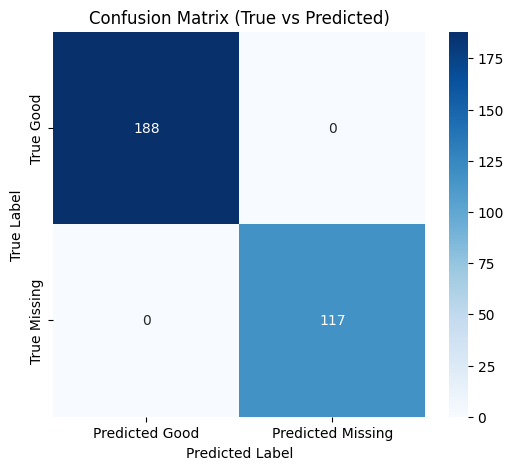


--- Segmentation and Classification Results (Sample 'Missing' Images) ---


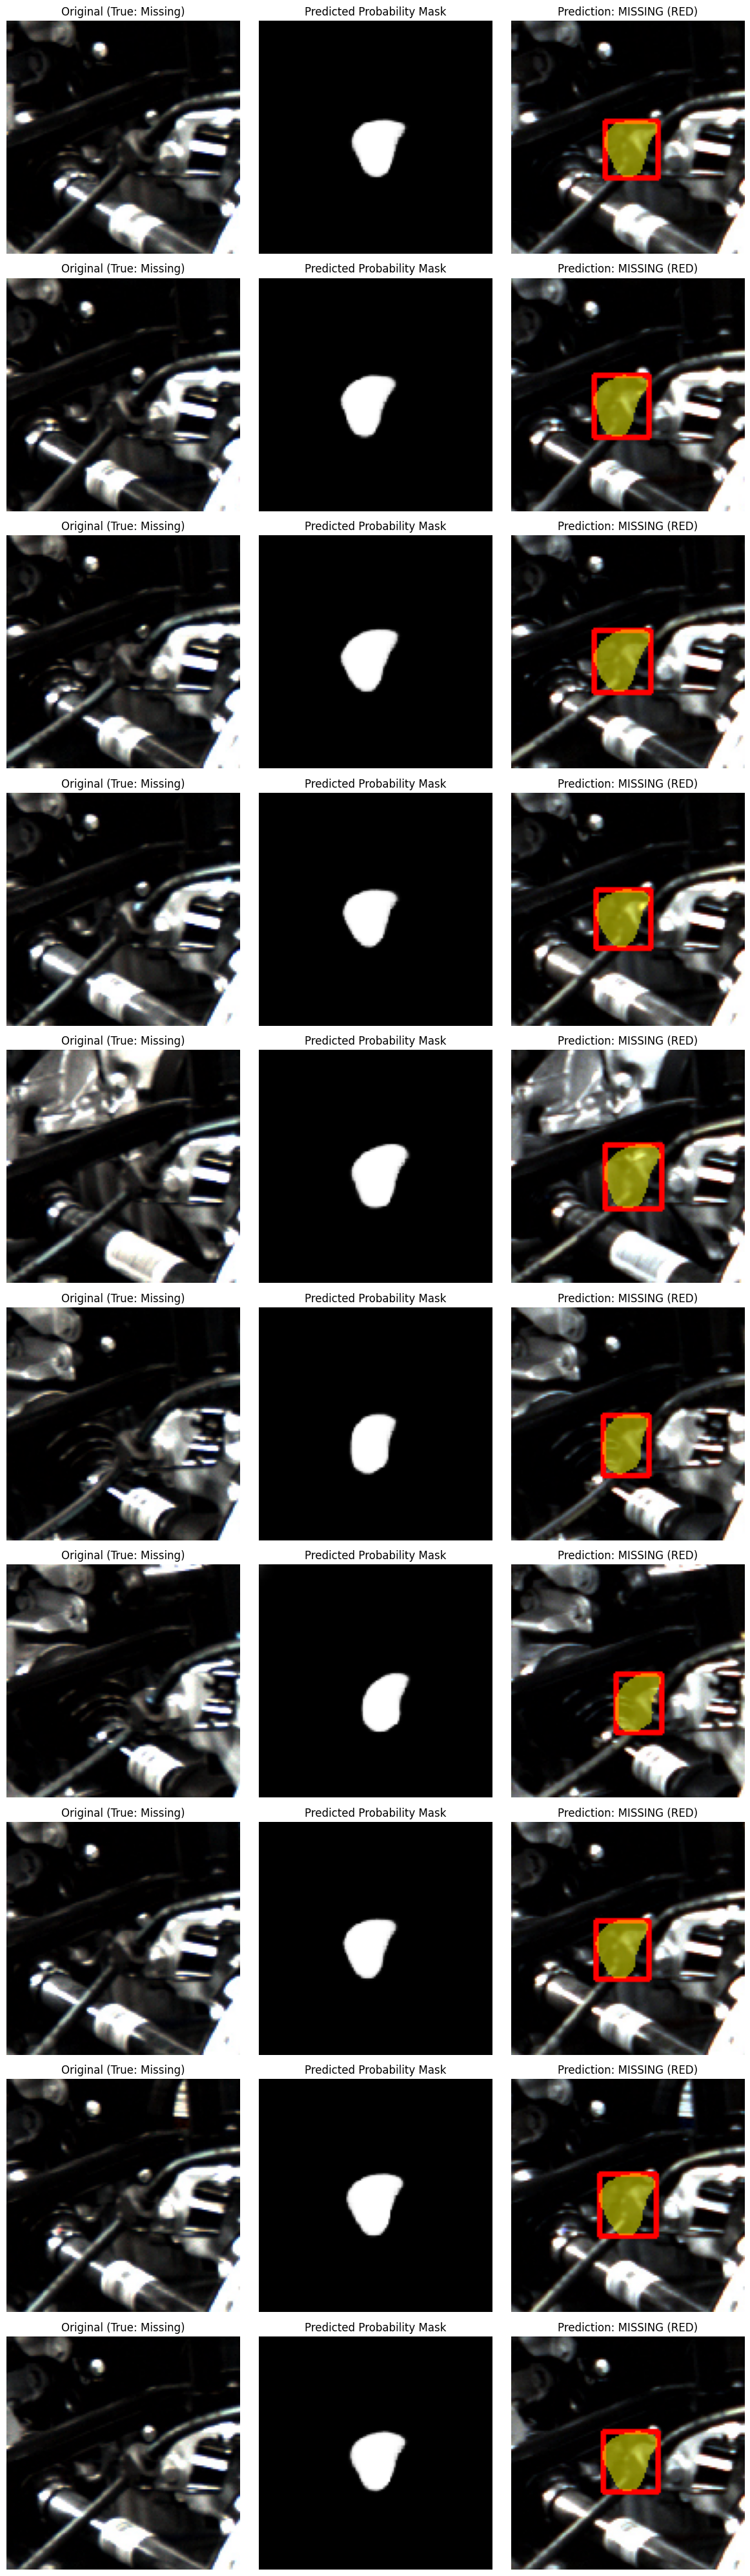

In [16]:
# ----------------------------------------------------------------------
# 6. การทดสอบและการประเมินผลลัพธ์
# ----------------------------------------------------------------------

def load_test_data(base_dir, img_size):
    """โหลดภาพ Good และ Missing สำหรับการทดสอบจริง"""
    X_test = []
    y_true_class = [] # 0: good, 1: missing

    # Load 'good' test images
    good_files = glob(os.path.join(base_dir, 'test', 'good', '*.png'))
    for img_path in good_files:
        img = img_to_array(load_img(img_path, target_size=img_size)) / 255.0
        X_test.append(img)
        y_true_class.append(0)

    # Load 'missing' test images
    missing_files = glob(os.path.join(base_dir, 'test', 'missing', '*.png'))
    for img_path in missing_files:
        img = img_to_array(load_img(img_path, target_size=img_size)) / 255.0
        X_test.append(img)
        y_true_class.append(1)

    return np.array(X_test), np.array(y_true_class)

print("\nLoading test data...")
X_test, y_true = load_test_data(DATA_DIR, IMG_SIZE)

# 6.1. ทำนาย Segmentation Mask และ Classification
print("Predicting segmentation masks...")
y_pred_masks = model.predict(X_test, verbose=0)

y_pred_class = []
for mask in y_pred_masks:
    # แปลง Mask ที่ทำนายเป็น Binary (0 หรือ 1) โดยใช้ SEGMENTATION_THRESHOLD ที่ลดลง
    binary_mask = (mask > SEGMENTATION_THRESHOLD).astype(np.uint8)

    # นับจำนวนพิกเซลที่เป็น '1' (Defect)
    defect_pixels = np.sum(binary_mask)

    # Classification: ถ้า Defect Pixels เกิน PIXEL_COUNT_THRESHOLD ให้เป็น Missing
    if defect_pixels > PIXEL_COUNT_THRESHOLD:
        y_pred_class.append(1) # 1 = missing/defect
    else:
        y_pred_class.append(0) # 0 = good

y_pred_class = np.array(y_pred_class)

# 6.2. คำนวณ Metric และ Confusion Matrix
print("\n--- Model Evaluation Metrics ---")
conf_matrix = confusion_matrix(y_true, y_pred_class)
accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class, zero_division=0)
recall = recall_score(y_true, y_pred_class, zero_division=0)
f1 = f1_score(y_true, y_pred_class, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix (True vs Predicted):\n  [[TN, FP]\n   [FN, TP]]")
print(conf_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=['Predicted Good', 'Predicted Missing'],
            yticklabels=['True Good', 'True Missing'])
plt.title("Confusion Matrix (True vs Predicted)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# 6.3. การแสดงผลลัพธ์ Segmentation และ Classification
def display_results(images, masks, predictions, true_labels, n=5):
    """แสดงตัวอย่างภาพพร้อม Bounding Box และ Segmentation Overlay"""

    # กรองเอาเฉพาะภาพ 'missing' ที่ทำนายแล้วมาแสดงเป็นตัวอย่างตามโจทย์
    missing_indices = np.where(true_labels == 1)[0]

    if len(missing_indices) == 0:
        print("No 'missing' images in test set to display.")
        return

    sample_indices = np.random.choice(missing_indices, min(n, len(missing_indices)), replace=False)

    print("\n--- Segmentation and Classification Results (Sample 'Missing' Images) ---")

    plt.figure(figsize=(4 * 3, n * 4))
    for i, idx in enumerate(sample_indices):
        original_img = (images[idx] * 255).astype(np.uint8)
        pred_mask = masks[idx].squeeze()
        predicted_class = predictions[idx]

        # 1. ภาพต้นฉบับ
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(original_img)
        plt.title(f"Original (True: {'Missing' if true_labels[idx]==1 else 'Good'})")
        plt.axis('off')

        # 2. Segmentation Mask (ทำนาย)
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
        plt.title("Predicted Probability Mask")
        plt.axis('off')

        # 3. ภาพพร้อมกรอบ Bounding Box และ Overlay
        display_img = original_img.copy()
        mask_binary = (pred_mask > SEGMENTATION_THRESHOLD).astype(np.uint8)

        # สี: แดง=Missing (1), เขียว=Good (0)
        box_color_rgb = (255, 0, 0) if predicted_class == 1 else (0, 255, 0)
        box_color_bgr = (box_color_rgb[2], box_color_rgb[1], box_color_rgb[0])

        contours, _ = cv2.findContours(mask_binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        has_defect_box = False
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > PIXEL_COUNT_THRESHOLD:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(display_img, (x, y), (x + w, y + h), box_color_bgr, 2)
                has_defect_box = True

        # Fallback: ตีกรอบทั้งภาพเป็นสีแดง หากทำนายว่า Missing แต่ไม่เจอ BBox
        if predicted_class == 1 and not has_defect_box:
             cv2.rectangle(display_img, (0, 0), (IMG_SIZE[1] - 1, IMG_SIZE[0] - 1), box_color_bgr, 2)

        # Overlay Mask (สีเหลือง)
        overlay = display_img.copy()
        # เปลี่ยนสี Defect Overlay เป็นสีเหลือง (B, G, R)
        overlay[mask_binary == 1] = [0, 255, 255]
        alpha = 0.5
        display_img = cv2.addWeighted(overlay, alpha, display_img, 1 - alpha, 0)

        # แสดงผล
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {'MISSING (RED)' if predicted_class==1 else 'GOOD (GREEN)'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# รันฟังก์ชันแสดงผลลัพธ์
display_results(X_test, y_pred_masks, y_pred_class, y_true, n=10)

In [17]:
import time

print("\n--- Measuring Inference Time per Image ---")

inference_times = []

# Loop through each test image and measure prediction time (limited to 40 images)
for i, img in enumerate(X_test[:40]): # Limit to first 40 images
    start_time = time.time()
    # model.predict expects a batch of images, so add a batch dimension
    _ = model.predict(np.expand_dims(img, axis=0), verbose=0)
    end_time = time.time()
    duration = end_time - start_time
    inference_times.append(duration)
    print(f"Image {i+1} inference time: {duration:.4f} seconds")

# Calculate and print average inference time
if inference_times:
    average_inference_time = sum(inference_times) / len(inference_times)
    print(f"\nAverage inference time per image: {average_inference_time:.4f} seconds")
else:
    print("No images processed to calculate inference time.")


--- Measuring Inference Time per Image ---
Image 1 inference time: 0.0747 seconds
Image 2 inference time: 0.0552 seconds
Image 3 inference time: 0.0555 seconds
Image 4 inference time: 0.0560 seconds
Image 5 inference time: 0.0560 seconds
Image 6 inference time: 0.0605 seconds
Image 7 inference time: 0.0601 seconds
Image 8 inference time: 0.0600 seconds
Image 9 inference time: 0.0592 seconds
Image 10 inference time: 0.0608 seconds
Image 11 inference time: 0.0599 seconds
Image 12 inference time: 0.0595 seconds
Image 13 inference time: 0.0568 seconds
Image 14 inference time: 0.0591 seconds
Image 15 inference time: 0.0601 seconds
Image 16 inference time: 0.0618 seconds
Image 17 inference time: 0.0575 seconds
Image 18 inference time: 0.0574 seconds
Image 19 inference time: 0.0562 seconds
Image 20 inference time: 0.0637 seconds
Image 21 inference time: 0.0560 seconds
Image 22 inference time: 0.0595 seconds
Image 23 inference time: 0.0589 seconds
Image 24 inference time: 0.0584 seconds
Image

In [18]:
model.save('defect_model.h5')